## Color analysis

In [1]:
import pandas as pd

In [2]:
cdf = pd.read_csv('frame_centroids.csv')

In [3]:
cdf.head()

,movie_id,movie_title,year,frame_id,centroid_id,red,green,blue
0,0,make_mine_music,1940,0,0,0.494841,0.333643,0.382833
1,0,make_mine_music,1940,0,1,0.538713,0.574225,0.639382
2,0,make_mine_music,1940,0,2,0.363670,0.420475,0.553765
3,0,make_mine_music,1940,0,3,0.244141,0.312930,0.425660
4,0,make_mine_music,1940,0,4,0.727626,0.745525,0.815441


In [4]:
cdf.shape

(150130, 8)

In [5]:
print('Total centroids:', cdf.shape[0])

Total centroids: 150130


In [6]:
print('Total frames:', cdf.shape[0]/10)

Total frames: 15013.0


In [7]:
print('Total movies:', len(cdf['movie_id'].unique()))

Total movies: 129


In [8]:
cdf['rgb'] = [(i[-3], i[-2], i[-1]) for i in cdf.values]
cdf.drop(columns=['red', 'green', 'blue'], axis=1, inplace=True)
cdf.head()

,movie_id,movie_title,year,frame_id,centroid_id,rgb
0,0,make_mine_music,1940,0,0,"(0.4948409661638601, 0.3336431652742103, 0.382..."
1,0,make_mine_music,1940,0,1,"(0.5387126649529148, 0.5742250325642928, 0.639..."
2,0,make_mine_music,1940,0,2,"(0.36366959978116187, 0.4204748239497644, 0.55..."
3,0,make_mine_music,1940,0,3,"(0.2441414631891009, 0.31293046306577865, 0.42..."
4,0,make_mine_music,1940,0,4,"(0.7276261576840661, 0.7455248882923641, 0.815..."


### Assign reference colors to centroid

In [9]:
import numpy as np
from skimage import color
from skimage.color import rgb2lab, deltaE_cie76
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [10]:
def to_image(pixel):
    return [[pixel]]

def to_pixel(image):
    return image[0][0]

def convert_rgb2lab(rgb_pixel):
    return to_pixel(color.rgb2lab(to_image(rgb_pixel)))

In [22]:
CSS_COLORS = [
    'black',
    'silver',
    'gray',
    'white',
    'maroon',
    'red',
    'purple',
    'fuchsia',
    'green',
    'lime',
    'olive',
    'yellow',
    'navy',
    'blue',
    'teal',
    'aqua'
]

CSS4_SELECTION_COLORS = [
    'black',
    'silver',
    'gray',
    'white',
    'lightcoral',
    'red',
    'brown',
    'chocolate',
    'tan',
    'orange',
    'goldenrod',
    'darkkhaki',
    'yellow',
    'darkseagreen',
    'green',
    'lime',
    'darkslategray',
    'darkcyan',
    'cyan',
    'deepskyblue',
    'steelblue',
    'navy',
    'blue',
    'darkviolet',
    'violet',
    'purple',
    'magenta',
    'deeppink',
    'pink'   
]

In [23]:
CSS4_HEX_COLORS = list(mcolors.CSS4_COLORS.values())
CSS4_RGB_COLORS = [mcolors.hex2color(c) for c in mcolors.CSS4_COLORS]
CSS4_LAB_COLORS = [convert_rgb2lab(c) for c in CSS4_RGB_COLORS]

BASE_RGB_COLORS = [[float(v) for v in c] for c in mcolors.BASE_COLORS.values()]
BASE_LAB_COLORS = [convert_rgb2lab(c) for c in BASE_RGB_COLORS]

CSS_HEX_COLORS  = [mcolors.CSS4_COLORS[c] for c in CSS_COLORS]
CSS_RGB_COLORS  = [mcolors.hex2color(c) for c in CSS_HEX_COLORS]
CSS_LAB_COLORS  = [convert_rgb2lab(c) for c in CSS_RGB_COLORS]

CSS4_SEL_HEX_COLORS  = [mcolors.CSS4_COLORS[c] for c in CSS4_SELECTION_COLORS]
CSS4_SEL_RGB_COLORS  = [mcolors.hex2color(c) for c in CSS4_SEL_HEX_COLORS]
CSS4_SEL_LAB_COLORS  = [convert_rgb2lab(c) for c in CSS4_SEL_RGB_COLORS]

In [25]:
colors = {
    'CSS': {
        'HEX': CSS_HEX_COLORS,
        'RGB': CSS_RGB_COLORS,
        'LAB': CSS_LAB_COLORS
    },
    'CSS4': {
        'HEX': CSS4_HEX_COLORS,
        'RGB': CSS4_RGB_COLORS,
        'LAB': CSS4_LAB_COLORS
    },
    'CSS4_SEL': {
        'HEX': CSS4_SEL_HEX_COLORS,
        'RGB': CSS4_SEL_RGB_COLORS,
        'LAB': CSS4_SEL_LAB_COLORS
    }
}

In [26]:
def get_ref_color(rgb_color, ref_colors):
    ref_lab_colors = colors[ref_colors]['LAB']
    ref_rgb_colors = colors[ref_colors]['RGB']
    ref_hex_colors = colors[ref_colors]['HEX']
    
    lab_color = convert_rgb2lab(rgb_color)
    
    min_distance = deltaE_cie76(lab_color, ref_lab_colors[0])
    nearest_ref_color = 0

    k = 1
    for c in ref_lab_colors[1:]: # CSS4_LAB_COLORS[0] already processed above
        tmp_distance = deltaE_cie76(lab_color, c)
        if (tmp_distance < min_distance):
            min_distance = tmp_distance
            nearest_ref_color = k
        k += 1

    return ref_rgb_colors[nearest_ref_color], ref_hex_colors[nearest_ref_color]

In [27]:
def add_ref_column(df, palette_id):
    df['ref_color_rgb_hex'] = df['rgb'].apply(lambda x: get_ref_color(x, palette_id))
    df[palette_id + '_ref_color_rgb'] = [i[0] for i in df['ref_color_rgb_hex']]
    df[palette_id + '_ref_color_hex'] = [i[1] for i in df['ref_color_rgb_hex']]
    df.drop(columns=['ref_color_rgb_hex'], axis=1, inplace=True)

In [28]:
%%time
add_ref_column(cdf, 'CSS')
add_ref_column(cdf, 'CSS4_SEL')
cdf.head()

CPU times: user 1min 14s, sys: 486 ms, total: 1min 14s
Wall time: 1min 14s


,movie_id,movie_title,year,frame_id,centroid_id,rgb,CSS_ref_color_rgb,CSS_ref_color_hex,CSS4_SEL_ref_color_rgb,CSS4_SEL_ref_color_hex
0,0,make_mine_music,1940,0,0,"(0.4948409661638601, 0.3336431652742103, 0.382...","(0.5019607843137255, 0.5019607843137255, 0.501...",#808080,"(0.5019607843137255, 0.5019607843137255, 0.501...",#808080
1,0,make_mine_music,1940,0,1,"(0.5387126649529148, 0.5742250325642928, 0.639...","(0.5019607843137255, 0.5019607843137255, 0.501...",#808080,"(0.5019607843137255, 0.5019607843137255, 0.501...",#808080
2,0,make_mine_music,1940,0,2,"(0.36366959978116187, 0.4204748239497644, 0.55...","(0.5019607843137255, 0.5019607843137255, 0.501...",#808080,"(0.27450980392156865, 0.5098039215686274, 0.70...",#4682B4
3,0,make_mine_music,1940,0,3,"(0.2441414631891009, 0.31293046306577865, 0.42...","(0.5019607843137255, 0.5019607843137255, 0.501...",#808080,"(0.1843137254901961, 0.30980392156862746, 0.30...",#2F4F4F
4,0,make_mine_music,1940,0,4,"(0.7276261576840661, 0.7455248882923641, 0.815...","(0.7529411764705882, 0.7529411764705882, 0.752...",#C0C0C0,"(0.7529411764705882, 0.7529411764705882, 0.752...",#C0C0C0


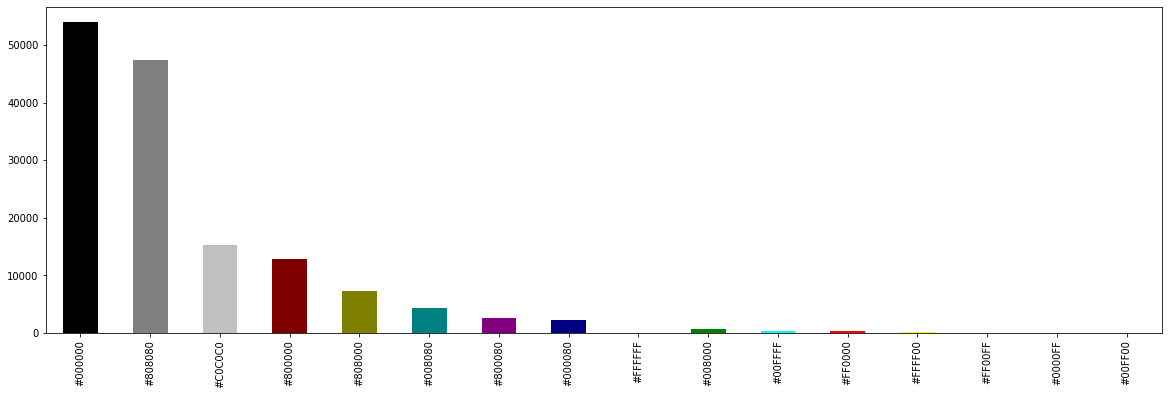

In [29]:
plt.figure(figsize = (20, 6))
cdf['CSS_ref_color_hex'].value_counts().plot(kind = 'bar', color = list(cdf['CSS_ref_color_hex'].value_counts().index))
plt.show()

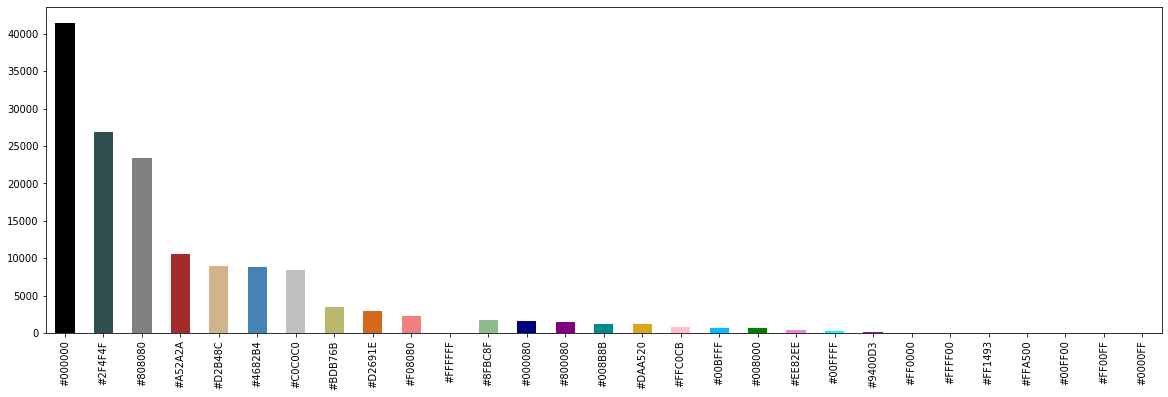

In [30]:
plt.figure(figsize = (20, 6))
cdf['CSS4_SEL_ref_color_hex'].value_counts().plot(kind = 'bar', color = list(cdf['CSS4_SEL_ref_color_hex'].value_counts().index))
plt.show()